# DSTL Satellite Imagery Feature Detection


In [1]:
!pip install shapely rasterio geopandas tifffile descartes

     |████████████████████████████████| 1.0 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 18.3 MB 12.2 MB/s eta 0:00:01
     |████████████████████████████████| 962 kB 63.3 MB/s eta 0:00:01
     |████████████████████████████████| 148 kB 70.3 MB/s eta 0:00:01
     |████████████████████████████████| 6.4 MB 53.0 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 4.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [14]:
import pandas as pd
import geopandas as gpd
import rasterio
import tifffile as tiff
import matplotlib.pyplot as plt
from shapely import wkt
from shapely import affinity
import shapely
from descartes import PolygonPatch
import os
from rasterio import plot as rplot
import json
import numpy as np
import glob

In [ ]:
%matplotlib inline

In [4]:
train_wkt = pd.read_csv('train_wkt_v4.csv')
train_wkt.set_index('ImageId',inplace=True)
train_wkt.head()

,ClassType,MultipolygonWKT
ImageId,,
6040_2_2,1,MULTIPOLYGON EMPTY
6040_2_2,2,MULTIPOLYGON EMPTY
6040_2_2,3,MULTIPOLYGON EMPTY
6040_2_2,4,MULTIPOLYGON (((0.003025 -0.007879000000000001...
6040_2_2,5,MULTIPOLYGON (((0.005311 -0.009044999999999999...


In [5]:
grid_sizes = pd.read_csv('grid_sizes.csv',names=['ImageId','Xmax','Ymax'],skiprows=1)
grid_sizes.set_index('ImageId',inplace=True)
print(grid_sizes.shape)
grid_sizes.head()

(450, 2)


,Xmax,Ymax
ImageId,,
6120_2_4,0.009180,-0.00904
6120_2_3,0.009169,-0.00904
6120_2_2,0.009188,-0.00904
6120_2_1,0.009188,-0.00904
6120_2_0,0.009188,-0.00904


In [6]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.set_index('ImageId',inplace=True)
sample_submission.head()

,ClassType,MultipolygonWKT
ImageId,,
6120_2_4,1,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
6120_2_4,2,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
6120_2_4,3,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
6120_2_4,4,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
6120_2_4,5,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."


In [14]:


# with open(overlay_fp) as f:
#     overlay = json.load(f)
    
# coords_set_1 = np.array(overlay['features'][0]['geometry']['coordinates']).squeeze()

In [11]:
def scale_image(img):
    '''
    scale the arrays within a rasterio datasetreader object to the range [0:1]
    '''
    test_img_scaled = np.empty(img.read().shape)
    for i,band in enumerate(img.read()):
        img_max = np.max(band)
        img_min = np.min(band)

        scaled_band = (band - img_min) * 1/(img_max-img_min)

        test_img_scaled[i] = scaled_band
        
    return test_img_scaled

In [7]:
#image files

base = '6010'
base_names = []
for i in range(5):
    row = i
    for j in range(5):
        col = j
        base_names.append(base+'_'+str(row)+'_'+str(col)+'.tif')

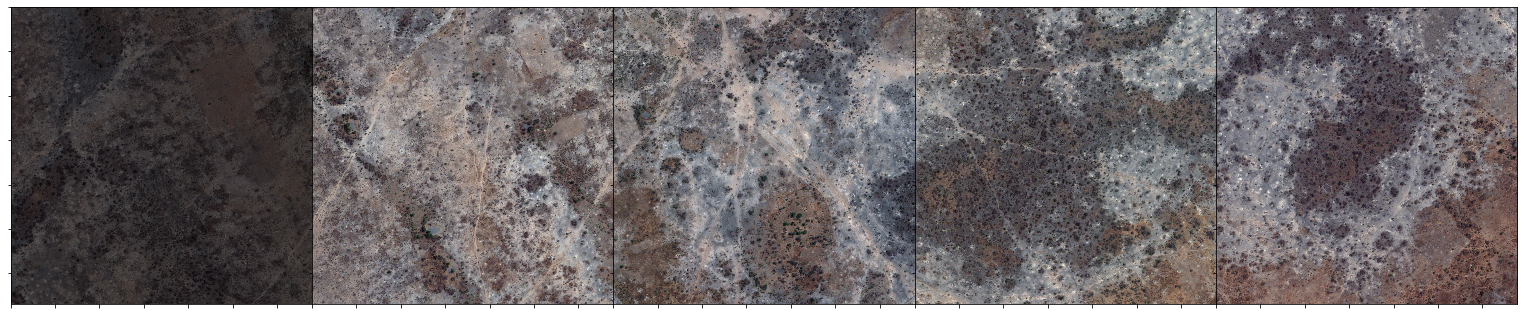

In [12]:
fig, axes = plt.subplots(1,5,figsize=(27,7))

plt.subplots_adjust(wspace=0, hspace=0)

for i,file in enumerate(base_names[0:5]):
    image = rasterio.open(os.path.join('three_band',file))
    scaled_image = scale_image(image)
    
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
    
    rplot.show(scale_image(image),ax=axes[i])
    

In [17]:
def scale_geometry(x, img, img_id):
    _,h,w = img.shape
    xmax, ymax = grid_sizes.loc[image_id]
    
    W = w**2 / (w+1)
    H = h**2 / (h+1)

    if type(x) != shapely.geometry.multipolygon.MultiPolygon:
        x,y = np.array(x.boundary)[:,0], np.array(x.boundary)[:,1]
        X = (x / xmax) * W
        Y = (y / ymax) * H
        scaled_coords = np.concatenate([X[:,None],Y[:,None]],axis=1)
        return shapely.geometry.Polygon(scaled_coords)
    else:
        polys = []
        for line in list(x.boundary.geoms):
                   
            x,y = np.array(line)[:,0], np.array(line)[:,1]
            X = (x / xmax) * W
            Y = (y / ymax) * H
            scaled_coords = np.concatenate([X[:,None],Y[:,None]],axis=1)
            polys.append(shapely.geometry.Polygon(scaled_coords))
        return shapely.geometry.MultiPolygon(polys)  

    

In [18]:
image_id = '6010_1_2'

In [19]:
overlay_fn = '006_VEG_L5_STANDALONE_TREES.geojson'
overlay_fp = os.path.join('train_geojson_v3',image_id,overlay_fn)

In [20]:
gdf = gpd.read_file(overlay_fp)

In [21]:
test_img = rasterio.open(os.path.join('three_band',image_id+'.tif'))

In [22]:
scaled_test = scale_image(test_img)

In [23]:
gdf['geometry'] = gdf['geometry'].apply(scale_geometry,args=(scaled_test,image_id))

In [24]:
gdf.to_file('gdf.geojson',driver='GeoJSON')

In [27]:
fig, ax = plt.subplots(1,figsize=(35,35))
for tree in gdf['geometry']:
    ax.add_patch(PolygonPatch(tree,alpha=0.65,ec='yellow',fc='ivory'))
rplot.show(scaled_test,ax=ax)

MemoryError: Unable to allocate 347. MiB for an array with shape (3349, 3396, 4) and data type float64

<Figure size 2520x2520 with 1 Axes>

In [246]:
def get_labeled_polygons(image_id):
    fp = os.path.join('train_geojson_v3',image_id)
    image = rasterio.open(os.path.join('three_band',image_id+'.tif'))
    image_scaled = scale_image(image)
    poly_dict = {}
    for f in glob.glob('*.geojson'):
        gdf = gpd.read_file(f)
        gdf['geometry'] = gdf['geometry'].apply(scale_geometry,args=(test_img_scaled,image_id))
        label = gdf['LABEL'][0]
        poly_dict[label] = gdf['geometry']
    return poly_dict

In [247]:
test_poly = get_labeled_polygons(image_id=image_id)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [248]:
test_poly

{}

In [ ]:
#next, isolate the train dataset.

train_images = sorted(train_wkt['ImageId'].unique())
test_images = sorted(sample_submission['ImageId'].unique())